In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [1]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os

init_notebook_mode(connected=True)
%matplotlib inline

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

## GLOBAL VARIABLES
dataset = "PU"
test_ratio = 0.2
windowSize = 33

def loadData(name):
    data_path = os.path.join(os.getcwd(),'drive/My Drive/Colab Notebooks/')
    if name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_tr.mat'))['PaviaUni_train']
        testlabels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels, testlabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca


def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

Using TensorFlow backend.


Using CUDA


In [2]:
X, y, ytest = loadData(dataset)
X.shape, y.shape, ytest.shape

((610, 340, 103), (610, 340), (610, 340))

In [3]:
K = 3
X,pca = applyPCA(X,numComponents=K)

X.shape

(610, 340, 3)

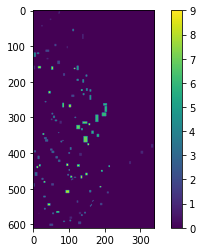

In [4]:
imgplot = plt.imshow(y)
plt.colorbar()

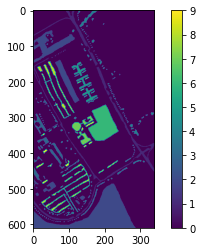

In [7]:
imgplot = plt.imshow(ytest)
plt.colorbar()

In [5]:
Xtest = X
X, y = createImageCubes(X, y, windowSize=windowSize)
X.shape, y.shape

((3921, 33, 33, 3), (3921,))

In [6]:
Xtest, ytest = createImageCubes(Xtest, ytest, windowSize=windowSize)
Xtest.shape, ytest.shape

((42776, 33, 33, 3), (42776,))

In [0]:
def resizeX(X):
    new = []
    for sample in range (X.shape[0]):
        temp = np.zeros((1, 224, 224, X.shape[3]))
        for layer in range (X.shape[3]):
            temp[0,:,:,layer] = np.resize(X[sample,:,:,layer], (224,224))
        new.append(temp)
    new = np.array(new)
    return new

In [0]:
resizedX = resizeX(X)
resizedX.shape

In [0]:
#Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)
Xtrain = X
ytrain = y
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3921, 33, 33, 3), (42776, 33, 33, 3), (3921,), (42776,))

In [0]:
ytrain = np_utils.to_categorical(ytrain)
ytest = np_utils.to_categorical(ytest)
ytrain.shape, ytest.shape

((3921, 9), (42776, 9))

In [0]:
model = keras.models.Sequential()
model_x = VGG16(include_top=False, weights='imagenet', input_shape=(33,33,3))
model.add(model_x)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(9, activation='softmax'))
for layer in model_x.layers[:]:
  layer.trainable = False
for layer in model_x.layers:
  sp = '         '[len(layer.name)-3:]
  print(layer.name,sp,layer.trainable)

model.summary()

58892288/58889256 [==============================] - 5s 0us/step
input_1       False
block1_conv1  False
block1_conv2  False
block1_pool   False
block2_conv1  False
block2_conv2  False
block2_pool   False
block3_conv1  False
block3_conv2  False
block3_conv3  False
block3_pool   False
block4_conv1  False
block4_conv2  False
block4_conv3  False
block4_pool   False
block5_conv1  False
block5_conv2  False
block5_conv3  False
block5_pool   False
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense

In [0]:
adam = Adam(lr=0.00001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=128, epochs=65, callbacks=callbacks_list)

Epoch 1/65
3921/3921 [==============================] - 9s 2ms/step - loss: 2.1606 - accuracy: 0.2471

Epoch 00001: accuracy improved from -inf to 0.24713, saving model to best-model.hdf5
Epoch 2/65
3921/3921 [==============================] - 2s 411us/step - loss: 1.9962 - accuracy: 0.3448

Epoch 00002: accuracy improved from 0.24713 to 0.34481, saving model to best-model.hdf5
Epoch 3/65
3921/3921 [==============================] - 2s 402us/step - loss: 1.8535 - accuracy: 0.4851

Epoch 00003: accuracy improved from 0.34481 to 0.48508, saving model to best-model.hdf5
Epoch 4/65
3921/3921 [==============================] - 2s 399us/step - loss: 1.7233 - accuracy: 0.5973

Epoch 00004: accuracy improved from 0.48508 to 0.59730, saving model to best-model.hdf5
Epoch 5/65
3921/3921 [==============================] - 2s 405us/step - loss: 1.6018 - accuracy: 0.6827

Epoch 00005: accuracy improved from 0.59730 to 0.68273, saving model to best-model.hdf5
Epoch 6/65
3921/3921 [==================

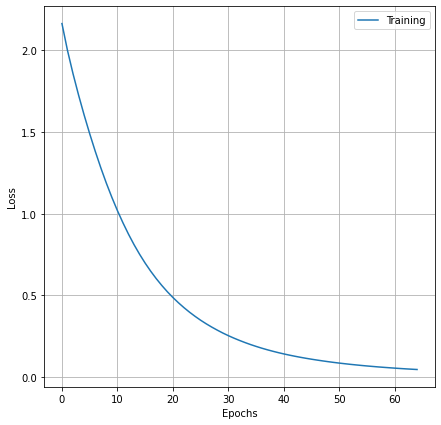

In [0]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
plt.ylabel('Loss') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig("loss_curve.pdf") 
plt.show()

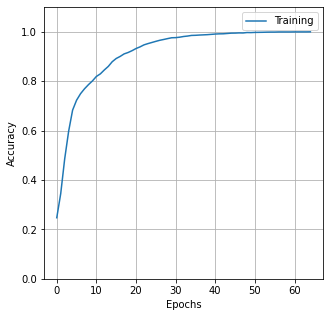

In [0]:
plt.figure(figsize=(5,5)) 
plt.ylim(0,1.1) 
plt.grid() 
plt.plot(history.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig("acc_curve.pdf") 
plt.show()

In [0]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.82      0.55      0.66      6631
           1       0.89      0.93      0.91     18649
           2       0.77      0.75      0.76      2099
           3       0.40      0.62      0.49      3064
           4       0.90      0.95      0.92      1345
           5       0.83      0.63      0.72      5029
           6       0.81      0.89      0.84      1330
           7       0.81      0.86      0.84      3682
           8       0.46      0.70      0.56       947

    accuracy                           0.79     42776
   macro avg       0.74      0.76      0.74     42776
weighted avg       0.81      0.79      0.80     42776



In [0]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [0]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [0]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

42776/42776 [==============================] - 36s 836us/step
